In [7]:
import numpy as np
import torch
import tkinter
import matplotlib.pyplot as plt
import matplotlib
import hdf5fileinout as hdf5io
import glob
import os
from pathlib import Path
from mpl_toolkits.mplot3d.art3d import Line3DCollection

from tqdm import tqdm
import torch_geometric as tg
import networkx as nx
from utils import computeNeighbors, computeNeighborsKDTree

In [25]:
G = tg.data.Data(x=torch.tensor([[0], [1], [2]]), edge_index=torch.tensor([[0, 1, 3], [2, 0, 4]]))
print(G.num_features)
G_nx = tg.utils.to_networkx(G)
nx.draw(G_nx)
plt.axis("off")
plt.show()

KeyError: 0

In [2]:
PATH_data = '../GRAND_DATA/GP300Outbox/' #We need to exit code in this notebook
progenitor = 'Proton'
zenVal = '_' + str(74.8)  # 63.0, 74.8, 81.3, 85.0, 87.1
gui = 'TKAgg'

#matplotlib.use(gui)

In [3]:
list_f = glob.glob(PATH_data+'*'+progenitor+'*'+zenVal+'*')
# list_f = glob.glob(PATH_data+'*')
print('Number of files = %i' % (len(list_f)))

Number of files = 496


# One File

In [5]:
file = 0
def load_event(file_id):
    inputfilename = glob.glob(list_f[file] + '/*' + progenitor + '*' + zenVal + '*.hdf5')[0]
    run_info = hdf5io.GetRunInfo(inputfilename)
    event_name = hdf5io.GetEventName(run_info, 0)
    antenna_info = hdf5io.GetAntennaInfo(inputfilename, event_name)
    n_ant = hdf5io.GetNumberOfAntennas(antenna_info) #=len(antenna_info)
    energy = run_info['Energy'][0]
    zenith = 180. - hdf5io.GetEventZenith(run_info, 0)
    azimuth = hdf5io.GetEventAzimuth(run_info, 0)-180.

    lstPositions = []
    antenna_id = antenna_info["ID"].value
    antenna_pos = np.concatenate((antenna_info['X'].value[:, np.newaxis], antenna_info['Y'].value[:, np.newaxis], antenna_info['Z'].value[:, np.newaxis]), axis=-1)
    
    for ant in range(n_ant):
        efield_loc = hdf5io.GetAntennaEfield(inputfilename, event_name,
                                            str(antenna_id[ant], 'UTF-8'))
        if ant == 0:
            efields = np.zeros((n_ant, ) + efield_loc.shape)

        efields[ant] = efield_loc
    return antenna_id, antenna_pos, efields, (energy, zenith, azimuth)




In [6]:
file = 0

antenna_id, antenna_pos, efields, (energy, zenith, azimuth) = load_event(file)
edge_index = computeNeighbors(antenna_pos)
edge_index = np.array(list(edge_index)) #Transform in array 
edge_index_mirrored = edge_index[:, [1, 0]]
edge_index = np.concatenate((edge_index, edge_index_mirrored), axis=0) #To have the edges in the 2 ways
edge_index = np.unique(edge_index, axis=0) #To remove the duplicates

In [7]:
#Peak to Peak energy
peak_to_peak_energy = np.max(efields[:, :, 1:], axis=1) - np.min(efields[:, :, 1:], axis=1)
print("X: max: ", np.max(peak_to_peak_energy[:, 0]), " min: ", np.min(peak_to_peak_energy[:, 0]))
print("Y: max: ", np.max(peak_to_peak_energy[:, 1]), " min: ", np.min(peak_to_peak_energy[:, 1]))
print("Z: max: ", np.max(peak_to_peak_energy[:, 2]), " min: ", np.min(peak_to_peak_energy[:, 2]))

X: max:  823.5999755859375  min:  5.378999948501587
Y: max:  23612.899993896484  min:  84.43999862670898
Z: max:  2644.0  min:  23.309999465942383


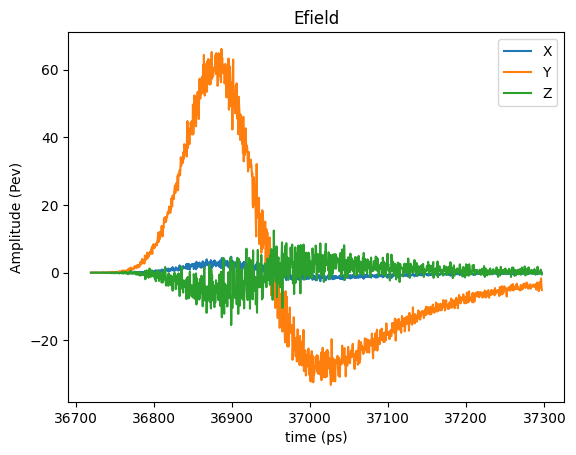

In [7]:
def plot_electromagnetic_field(efields, ant_id, title="Efield"):
    plt.plot(efields[ant_id, :, 0], efields[ant_id, :, 1], label="X")
    plt.plot(efields[ant_id, :, 0], efields[ant_id, :, 2], label="Y")
    plt.plot(efields[ant_id, :, 0], efields[ant_id, :, 3], label="Z")
    plt.legend()
    plt.title(title)
    plt.xlabel("time (ps)")
    plt.ylabel("Amplitude (Pev)")
    plt.show()

ant = 50
plot_electromagnetic_field(efields, ant)

In [8]:
from scipy.ndimage import gaussian_filter1d

def smooth(efields, kernel_size=12):
    """Smooth efields for an event
    """
    filter = np.ones(kernel_size)
    
    #plot filter
    """
    plt.plot([(i-(len(np.pad(filter, kernel_size))/2))*0.5 for i in range(len(np.pad(filter, kernel_size)))], np.pad(filter, kernel_size))
    plt.title("filter")
    plt.ylabel("filter value")
    plt.xlabel("time (ps)")
    plt.show()
    """

    return np.apply_along_axis(lambda m: np.convolve(m, filter, mode="same")/np.sum(filter), axis=1, arr=efields)
    
def smooth_ant(efields, ant_id, kernel_size=5):
    """Smooth a efields signal for an antenna
    """
    efields[ant_id, :, 1] = np.convolve(efields[ant_id, :, 1], np.ones(kernel_size), mode="same")/np.sum(filter)
    efields[ant_id, :, 2] = np.convolve(efields[ant_id, :, 2], np.ones(kernel_size), mode="same")/np.sum(filter)
    efields[ant_id, :, 3] = np.convolve(efields[ant_id, :, 3], np.ones(kernel_size), mode="same")/np.sum(filter)
    
    return efields

efields[:, :, 1:] = smooth(efields[:, :, 1:])
plot_electromagnetic_field(efields, ant)

NameError: name 'plot_electromagnetic_field' is not defined

18247.756


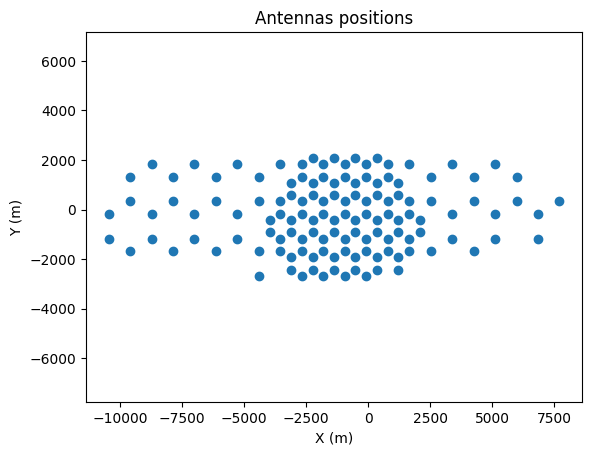

In [98]:
file = 3
antenna_id, antenna_pos, efields, (energy, zenith, azimuth) = load_event(file)


def computer_air_shower_diameter(efields, antenna_pos):
    max_dist = 0
    max_dist_ind = (0, 0)

    for ant in range(len(antenna_pos)):
        for ant2 in range(ant +1, len(antenna_pos)):
            if np.linalg.norm(antenna_pos[ant, :2] - antenna_pos[ant2, :2]) > max_dist:
                max_dist = np.linalg.norm(antenna_pos[ant, :2] - antenna_pos[ant2, :2])
                max_dist_ind = (ant, ant2)

    return max_dist, max_dist_ind

max_dist, max_dist_ind = computer_air_shower_diameter(efields, antenna_pos)

print(max_dist)
plt.scatter(antenna_pos[:, 0], antenna_pos[:, 1])
plt.axis("equal")
plt.title("Antennas positions")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.show()


# All files

In [12]:
antenna_pos_all_events = []
antenna_pos_id_dict = {}
antenna_id_all_events = []
efields_all_events = []
smooth_efields_all_events = []
energy_all_events = []
zenith_all_events = []
azimuth_all_events = []
edge_index_all_events = []
n_samples = 0
for file in tqdm(range(len(list_f))):
    antenna_id, antenna_pos, efields, (energy, zenith, azimuth) = load_event(file)
    
    n_samples += len(antenna_pos)
    
    edge_index = computeNeighbors(antenna_pos)
    edge_index = np.array(list(edge_index)) #Transform in array 
    edge_index_mirrored = edge_index[:, [1, 0]]
    edge_index = np.concatenate((edge_index, edge_index_mirrored), axis=0) #To have the edges in the 2 ways
    edge_index = np.unique(edge_index, axis=0) #To remove the duplicates
    
    smooth_efields = np.copy(efields)
    smooth_efields[:, :, 1:] = smooth(efields[:, :, 1:])
    
    for incr in range(len(antenna_pos)):
        pos = tuple(antenna_pos[incr])
        if pos not in antenna_pos_id_dict:
            antenna_pos_id_dict[pos] = set()
        antenna_pos_id_dict[pos].add(antenna_id[incr])
    
    antenna_pos_all_events.append(antenna_pos)
    antenna_id_all_events.append(antenna_id)
    efields_all_events.append(efields)
    smooth_efields_all_events.append(smooth_efields)
    energy_all_events.append(energy)
    zenith_all_events.append(zenith)
    azimuth_all_events.append(azimuth)
    edge_index_all_events.append(edge_index)



100%|██████████| 496/496 [07:46<00:00,  1.06it/s]


# Antennas

In [59]:
#Test to check that the antenna has the same Z position 
for i in range(300):
    antenna_id = b'A' + str(i).encode('utf-8')
    lst_pos = []
    for event in range(len(antenna_id_all_events)):
        indicie = np.where(antenna_id_all_events[event] == antenna_id)[0]
        if len(indicie)>0:
            pos = antenna_pos_all_events[event][indicie[0]]
            lst_pos.append(pos[2])
    if len(np.unique(lst_pos))>1:
        print(np.unique(lst_pos))

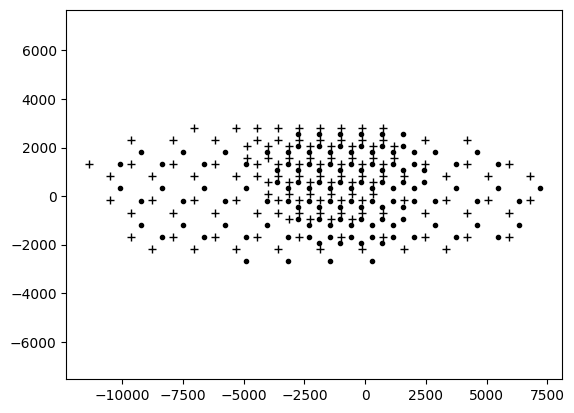

In [42]:
plt.plot(antenna_pos_all_events[10][:, 0], antenna_pos_all_events[10][:, 1], 'k.')
plt.plot(antenna_pos_all_events[0][:, 0], antenna_pos_all_events[0][:, 1], 'k+')
plt.axis('equal')
plt.show()

In [74]:
antenna_id_to_pos = {}
normalization_lst = []
for event in range(len(antenna_id_all_events)):
    normalization = None
    for incr in range(len(antenna_id_all_events[event])):
        antenna = antenna_id_all_events[event][incr]
        if antenna in antenna_id_to_pos:
            normalization = np.array(antenna_pos_all_events[event][incr]) - np.array(antenna_id_to_pos[antenna])
    if normalization is None:
        antenna_id_to_pos[antenna_id_all_events[event][0]] = antenna_pos_all_events[event][0]
        normalization = np.zeros((3,))
        
    for ant in range(len(antenna_id_all_events[event])):
        antenna = antenna_id_all_events[event][ant]
        if antenna in antenna_id_to_pos:
            #print(antenna_id_to_pos[antenna] - antenna_pos_all_events[event][ant] - normalization)
            if (antenna_id_to_pos[antenna] != antenna_pos_all_events[event][ant] - normalization).all():
                raise Exception("It can't be normalized")
        else:
            antenna_id_to_pos[antenna] = antenna_pos_all_events[event][ant] - normalization
            
    normalization_lst.append(normalization)
    #print(f"number of normalized antennas: {len(antenna_id_to_pos)}")

In [ ]:
antenna_id_to_pos

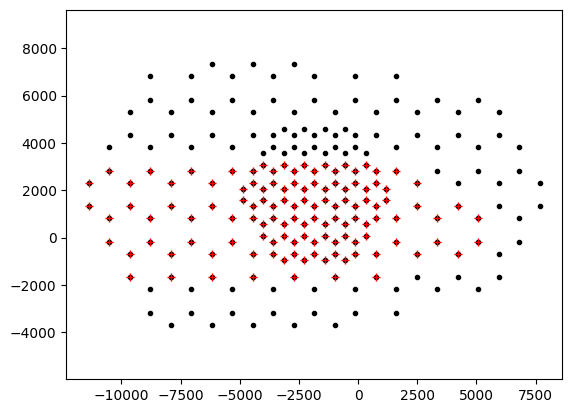

In [92]:
event = 75
plt.plot([values[0] for keys, values in antenna_id_to_pos.items()], [values[1] for keys, values in antenna_id_to_pos.items()], 'k.')
plt.plot(antenna_pos_all_events[event][:, 0] - normalization_lst[event][0], antenna_pos_all_events[event][:, 1] - normalization_lst[event][1], 'r+')
plt.axis('equal')
plt.show()

# Peak to Peak

In [11]:

print("nb samples: ", n_samples)

peak_to_peak_all, peak_to_peak_arr, peak_to_peak_ind = compute_peak2peak(efields_all_events)

print("X: max: ", np.max(peak_to_peak_arr[:, 0, 0]), " min: ", np.min(peak_to_peak_arr[:, 1, 0]))
print("Y: max: ", np.max(peak_to_peak_arr[:, 0, 1]), " min: ", np.min(peak_to_peak_arr[:, 1, 1]))
print("Z: max: ", np.max(peak_to_peak_arr[:, 0, 2]), " min: ", np.min(peak_to_peak_arr[:, 1, 2]))

print("X: max: event:", np.argmax(peak_to_peak_arr[:, 0, 0]), "ant: ", np.max(peak_to_peak_ind[np.argmax(peak_to_peak_arr[:, 0, 0]), 0, 0]), " min: event", np.argmin(peak_to_peak_arr[:, 1, 0]), "ant: ", np.min(peak_to_peak_ind[np.argmin(peak_to_peak_arr[:, 1, 0]), 1, 0]))
print("Y: max: event:", np.argmax(peak_to_peak_arr[:, 0, 1]), "ant: ", np.max(peak_to_peak_ind[np.argmax(peak_to_peak_arr[:, 0, 1]), 0, 1]), " min: event", np.argmin(peak_to_peak_arr[:, 1, 1]), "ant: ", np.min(peak_to_peak_ind[np.argmin(peak_to_peak_arr[:, 1, 1]), 1, 1]))
print("Z: max: event:", np.argmax(peak_to_peak_arr[:, 0, 2]), "ant: ", np.max(peak_to_peak_ind[np.argmax(peak_to_peak_arr[:, 0, 2]), 0, 2]), " min: event", np.argmin(peak_to_peak_arr[:, 1, 2]), "ant: ", np.min(peak_to_peak_ind[np.argmin(peak_to_peak_arr[:, 1, 2]), 1, 2]))


nb samples:  58822
X: max:  1315.5999755859375  min:  0.24309999495744705
Y: max:  27975.600006103516  min:  5.431999921798706
Z: max:  4576.0  min:  1.010200023651123
X: max: event: 283 ant:  44.0  min: event 270 ant:  9.0
Y: max: event: 269 ant:  97.0  min: event 482 ant:  53.0
Z: max: event: 283 ant:  44.0  min: event 225 ant:  23.0


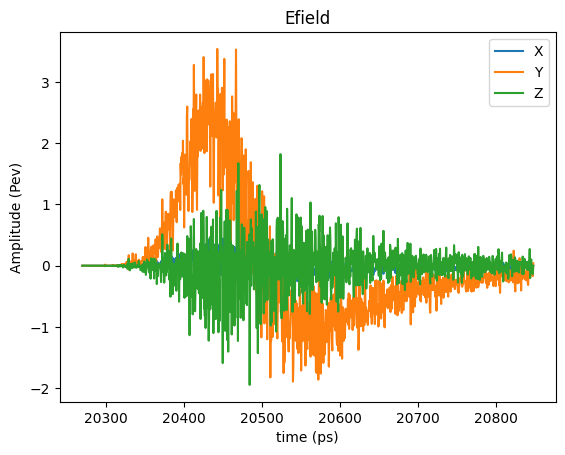

b'A171'


In [12]:
plot_electromagnetic_field(efields_all_events[482], 53)
print(antenna_id_all_events[482][53])
for i in range(len(antenna_id_all_events)):
    if b'A35' in antenna_id_all_events[i]:
        ind = np.where(antenna_id_all_events[i]==b'A35')[0]
        print(i, ind)
        plot_electromagnetic_field(efields_all_events[i], ind[0])

(487, 3)


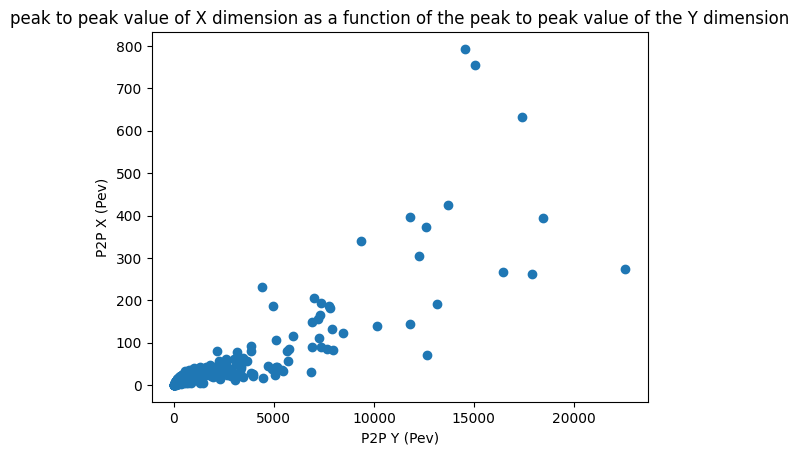

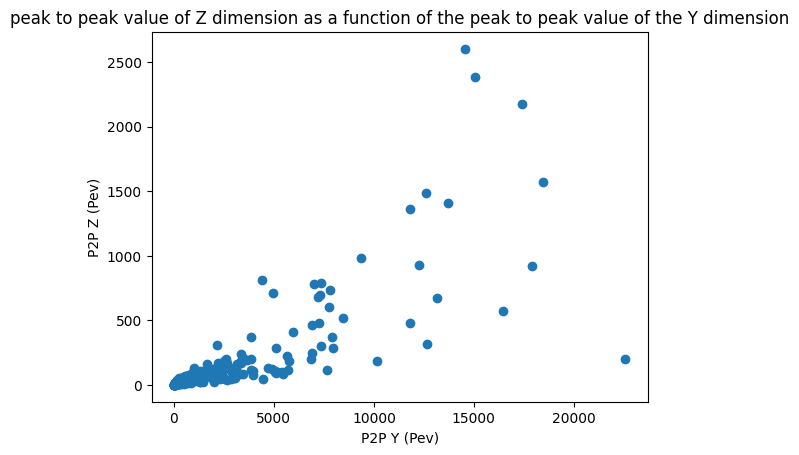

In [30]:
peak_to_peak_same_ant = []
ant_id = b'A254'
for event in range(len(peak_to_peak_all)):
    if ant_id in antenna_id_all_events[event]:
        ant_nb = np.where(antenna_id_all_events[event] == ant_id)[0][0]
        peak_to_peak_same_ant.append(peak_to_peak_all[event][ant_nb])

peak_to_peak_same_ant = np.array(peak_to_peak_same_ant)
print(peak_to_peak_same_ant.shape)
plt.scatter(peak_to_peak_same_ant[:, 1], peak_to_peak_same_ant[:, 0])
plt.title("peak to peak value of X dimension as a function of the peak to peak value of the Y dimension")
plt.xlabel("P2P Y (Pev)")
plt.ylabel("P2P X (Pev)")
plt.figure()
plt.title("peak to peak value of Z dimension as a function of the peak to peak value of the Y dimension")
plt.xlabel("P2P Y (Pev)")
plt.ylabel("P2P Z (Pev)")
plt.scatter(peak_to_peak_same_ant[:, 1], peak_to_peak_same_ant[:, 2])
plt.show()

# Antenna distribution

In [ ]:
distrib_dict = {}
for i in range(len(antenna_id_all_events)):
    for ant in antenna_id_all_events[i]:
        if ant in distrib_dict:
            distrib_dict[ant] += 1
        else:
            distrib_dict[ant] = 1

print(f"number of antennas ID: {len(distrib_dict)}" )
print(sorted(distrib_dict.items(), key=lambda x:x[1]))

# Length 

In [ ]:
#Length of the events
min_length = np.inf
min_length_index = None

max_length = 0
max_length_index = None

for i in range(len(efields_all_events)):
    length = efields_all_events[i].shape[1] #0 is the number of antennas, 1 the length of the event and 2 the 4 coordinates 
    if length < min_length:
        min_length = length
        min_length_index = i
        
    if length > max_length:
        max_length = length
        max_length_index = i

print(f"max_length = {max_length}, min_length = {min_length}")
print(f"max_length_index = {max_length_index}, min_length_index = {min_length_index}")

max_length = 1582, min_length = 1120
max_length_index = 218, min_length_index = 96


# Time diff between peaks(with Smoothing)

In [ ]:
# Time differences between the two spikes
time_diff_all, time_diff_peak, time_diff_peak_index, smooth_time_diff_peak, smooth_time_diff_peak_index = compute_time_diff(efields_all_events)

print("Y: max: ", np.max(time_diff_peak[:, 0]), " min: ", np.min(time_diff_peak[:, 1]))

print("Y_index: max: ", np.argmax(time_diff_peak[:, 0]), " ant: ", time_diff_peak_index[np.argmax(time_diff_peak[:, 0]),0 ], " min: ", np.argmin(time_diff_peak[:, 1]), " ant: ", time_diff_peak_index[np.argmin(time_diff_peak[:, 1]), 1])

print("Smooth Y: max: ", np.max(smooth_time_diff_peak[:, 0]), " min: ", np.min(smooth_time_diff_peak[:, 1]))

print("Smooth Y_index: max: ", np.argmax(smooth_time_diff_peak[:, 0]), " ant: ", smooth_time_diff_peak_index[np.argmax(smooth_time_diff_peak[:, 0]),0 ], " min: ", np.argmin(smooth_time_diff_peak[:, 1]), " ant: ", smooth_time_diff_peak_index[np.argmin(smooth_time_diff_peak[:, 1]), 1])

Y: max:  208.5  min:  1.0
Y_index: max:  354  ant:  58.0  min:  1  ant:  70.0
Smooth Y: max:  203.0  min:  6.0
Smooth Y_index: max:  297  ant:  2.0  min:  1  ant:  22.0


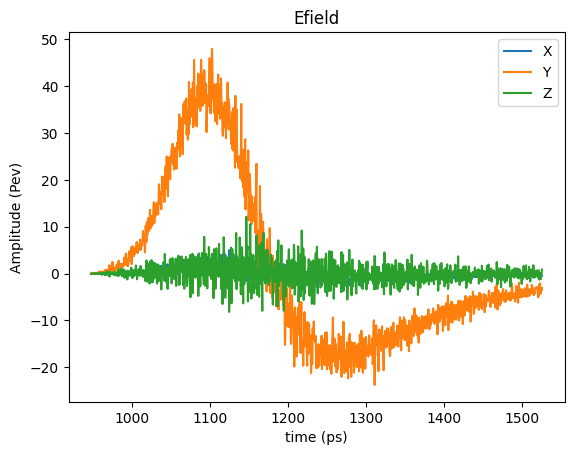

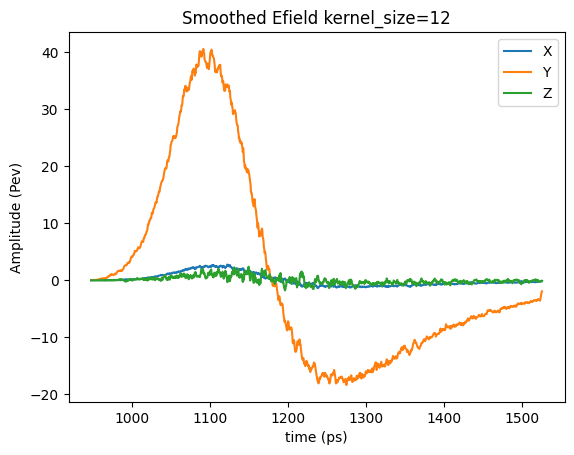

In [ ]:
plot_electromagnetic_field(efields_all_events[354], 58)
plot_electromagnetic_field(smooth_efields_all_events[354], 58, title="Smoothed Efield kernel_size=12")

# 10% of the peak

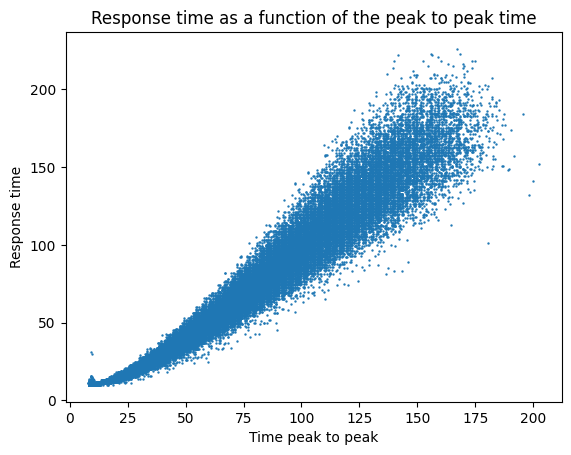

In [ ]:
    
indicie_max_arr, tau_arr = compute_time_response(smooth_efields_all_events)

flat_indicie_max_arr = np.array([item for sublist in indicie_max_arr for item in sublist])
flat_tau_arr = np.array([item for sublist in tau_arr for item in sublist])

antenna = b'A233'
flat_antenna_id = np.array([item for sublist in antenna_id_all_events for item in sublist])
flat_antenna_cond = np.where(flat_antenna_id==antenna)[0]

flat_time_diff_all = np.array([item for sublist in time_diff_all for item in sublist])
plt.scatter(flat_time_diff_all, flat_indicie_max_arr-flat_tau_arr, s=0.5)
#plt.scatter(flat_time_diff_all[flat_antenna_cond], flat_indicie_max_arr[flat_antenna_cond]-flat_tau_arr[flat_antenna_cond], s=0.5)
#plt.scatter(time_diff_all[482], np.array(indicie_max_arr[482])-np.array(tau_arr[482]))
plt.title("Response time as a function of the peak to peak time")
plt.xlabel("Time peak to peak")
plt.ylabel("Response time")
plt.show()

# Energy

max:  3.9808000000000003 min:  0.11987
[114. 135. 131. 116.]


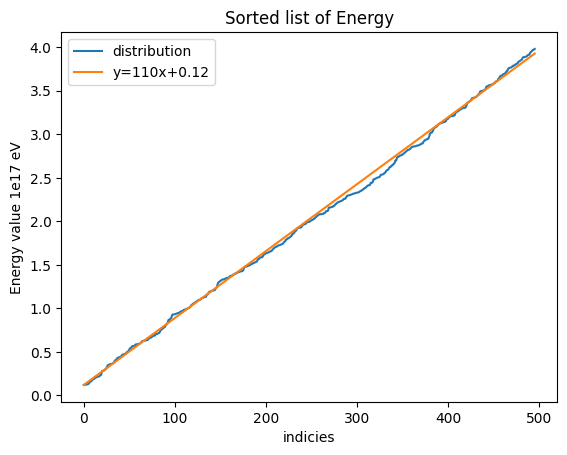

In [ ]:
print("max: ", np.max(energy_all_events), "min: ", np.min(energy_all_events))
bins = np.zeros((4,))
bins[np.unique(np.floor(energy_all_events).astype(np.int8), return_counts=True)[0]] = np.unique(np.floor(energy_all_events).astype(np.int8), return_counts=True)[1]
print(bins)

plt.plot([i for i in range(len(energy_all_events))], np.sort(energy_all_events), label="distribution")
plt.plot([i for i in range(len(energy_all_events))], [0.12 + i/130 for i in range(len(energy_all_events))], label="y=110x+0.12")
plt.legend()
plt.title("Sorted list of Energy")
plt.xlabel("indicies")
plt.ylabel("Energy value 1e17 eV")
plt.show()

# Azimuth and Zenith

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

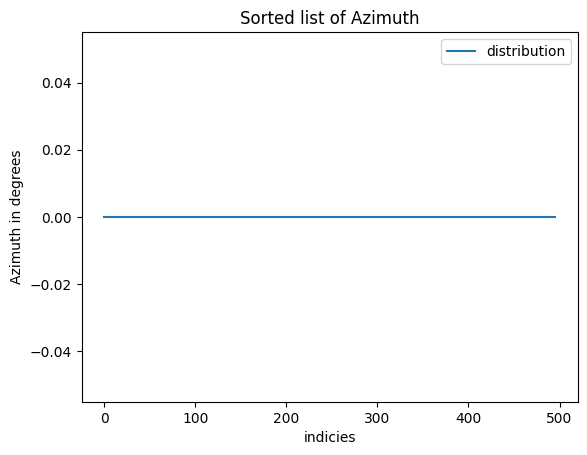

In [ ]:
print(azimuth_all_events)
print(np.sort(azimuth_all_events))
plt.plot([i for i in range(len(azimuth_all_events))], np.sort(azimuth_all_events), label="distribution")
#plt.plot([i for i in range(len(azimuth_all_events))], [0.12 + i/130 for i in range(len(azimuth_all_events))], label="y=110x+0.12")
plt.legend()
plt.title("Sorted list of Azimuth")
plt.xlabel("indicies")
plt.ylabel("Azimuth in degrees")
plt.show()

# Corelation

## Amplitude vs Time diff

In [ ]:
from copy import deepcopy

smooth_efields_all_events = deepcopy(efields_all_events)
for event in range(len(efields_all_events)):
    smooth_efields_all_events[event][:, :, 1:] = gaussian_filter1d(efields_all_events[event][:, :, 1:], sigma=5, axis=1)

peak_to_peak_all, _, _ = compute_peak2peak(smooth_efields_all_events)
time_diff_all, _, _, _, _ = compute_time_diff(smooth_efields_all_events)


In [ ]:
flat_peak_to_peak = np.array([item for sublist in peak_to_peak_all for item in sublist[:, 1]])
flat_time_diff = np.array([item for sublist in time_diff_all for item in sublist])

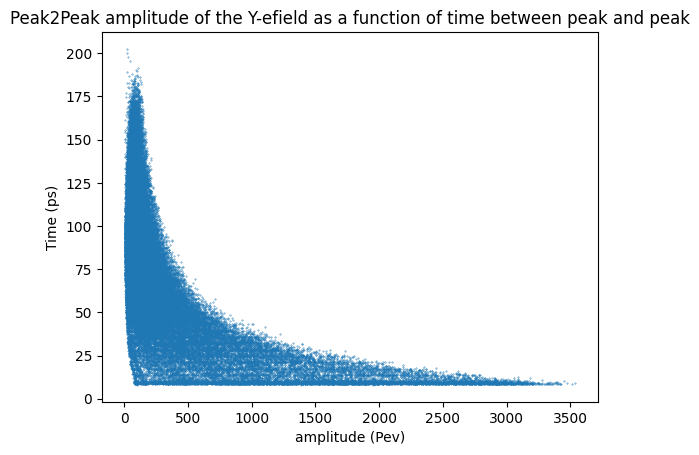

In [ ]:
plt.scatter(flat_peak_to_peak, flat_time_diff, s=0.1)
plt.title("Peak2Peak amplitude of the Y-efield as a function of time between peak and peak")
plt.xlabel("amplitude (Pev)")
plt.ylabel("Time (ps)")
plt.show()

## Diameter of the circle as a function of energy

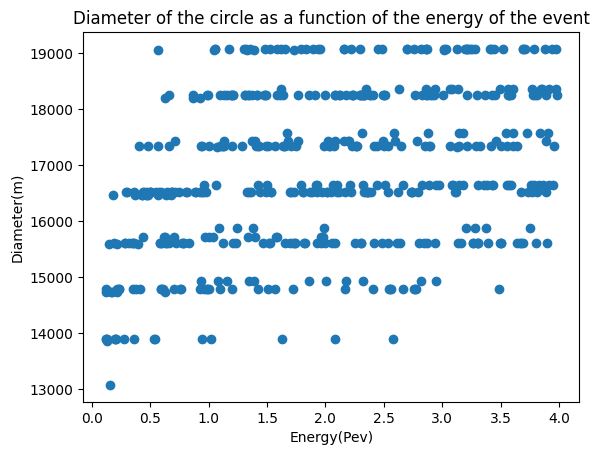

In [99]:
diam_all_events = []
for event in range(len(efields_all_events)):
    diam_all_events.append(computer_air_shower_diameter(efields_all_events[event], antenna_pos_all_events[event] - normalization_lst[event])[0])

plt.scatter(energy_all_events, diam_all_events)
plt.title("Diameter of the circle as a function of the energy of the event")
plt.xlabel("Energy(Pev)")
plt.ylabel("Diameter(m)")
plt.show()